In [2]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. NC Well Arsenic/P1011.2. Analyses/P1011.2.2. Arsenic Prediction/Output')
cur_date = "012024"

library(readxl)
library(openxlsx)
library(lubridate)
library(tidyverse)
library(gtsummary)
library(caret)
library(e1071)
library(Hmisc)
library(randomForest)
library(pROC)
library(themis)
#library(rlang)

# reading in file
well_data = data.frame(read_excel("Input/Imputed_Well_Data_080823.xlsx")) 


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.3     ✔ readr   2.1.4
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.3     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘Hmisc’


The following object is masked from ‘package:e1071’:

    impute


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


rand

In [3]:
head(well_data)

,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Geology,Soil_Type,Landuse,Longitude,Latitude,Stream_Distance,Elevation,Metal,Concentration,Detect_Concentration
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,1006004,960,12-155,9/24/12,52,165,41,60.0,7.7,Carolina Slate Belt - CZmd3,BdB2,81,-80.29918,35.17970,811.9613,611.499,Ar,1.531414,ND
2,1024009,1803,15-177,12/17/15,40,445,42,2.0,7.3,Carolina Slate Belt - CZfv2,GsB,81,-80.31061,35.15487,341.7654,688.452,Ar,2.348528,ND
3,1054019,1647,14-212,2/2/15,45,160,40,40.0,7.4,Carolina Slate Belt - CZmd3,GsB,81,-80.33170,35.16158,634.2669,692.789,Ar,2.043848,ND
4,1057017,970,12-169,10/22/12,42,440,57,1.5,8.0,Carolina Slate Belt - CZmd2,BaB,42,-80.32263,35.13962,855.4713,692.789,Ar,35.000000,D
5,1060006,533,10-239,1/3/11,48,120,42,25.0,7.1,Carolina Slate Belt - CZmd2,BdB2,43,-80.32911,35.13027,163.5688,683.387,Ar,2.297118,ND
6,1066006,1795,15-224,12/15/15,60,280,32,10.0,8.2,Carolina Slate Belt - CZmd2,BaB,22,-80.32205,35.10479,725.7672,614.599,Ar,53.000000,D


Using `water_sample_date`, `casing_depth`, `well_depth`, `static_water_depth`, `pH`, `flow_rate`, `geology`, `soil_type`, `landuse`, `latitude`, and `longitude` to predict with As concentration falls above or below a certain threshold. RF and SVM?? models will be built to predict concentration that has binarized in 3 different ways:

1. Detect vs. Non-Detect
2. Limit of Detection (< or >= 5ppb)
3. EPA's Maximum Contaminant Level (MCL) (< or >= 10ppb)

Starting by creating 2 additional variables for above and below 5 and 10ppb and calculating some summary statistics to determine if there are any signficiant differenes between the predictor variables for each outcome variable, but omitted categorical variables for simplicity. 

In [4]:
arsenic_data = well_data %>%
    mutate(Five_Threshold = relevel(factor(ifelse(Concentration >= 5, 1, 0)), ref = "0"),
          Ten_Threshold = relevel(factor(ifelse(Concentration >= 10, 1, 0)), ref = "0"),
           # making this col into a factor
          Detect_Concentration = relevel(factor(ifelse(Detect_Concentration == "D", 1, 0)), ref = "0"),
          # converting water sample date from a character to a date type 
          Water_Sample_Date = mdy(Water_Sample_Date),
          # converting missing records to an "other" category
          Landuse = ifelse(Landuse %in% NA, "Other", Landuse)) %>%

    # filtering for Arsenic only
    filter(Metal == "Ar") %>%
    # cleaning up geological categories 
    separate(Geology, c(NA, "Geology"), sep = "-") 

head(arsenic_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Water_Sample_Date = mdy(Water_Sample_Date)`.
Caused by warning:
!  6 failed to parse.”


,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Geology,⋯,Landuse,Longitude,Latitude,Stream_Distance,Elevation,Metal,Concentration,Detect_Concentration,Five_Threshold,Ten_Threshold
,<chr>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<fct>,<fct>
1,1006004,960,12-155,2012-09-24,52,165,41,60.0,7.7,CZmd3,⋯,81,-80.29918,35.17970,811.9613,611.499,Ar,1.531414,0,0,0
2,1024009,1803,15-177,2015-12-17,40,445,42,2.0,7.3,CZfv2,⋯,81,-80.31061,35.15487,341.7654,688.452,Ar,2.348528,0,0,0
3,1054019,1647,14-212,2015-02-02,45,160,40,40.0,7.4,CZmd3,⋯,81,-80.33170,35.16158,634.2669,692.789,Ar,2.043848,0,0,0
4,1057017,970,12-169,2012-10-22,42,440,57,1.5,8.0,CZmd2,⋯,42,-80.32263,35.13962,855.4713,692.789,Ar,35.000000,1,1,1
5,1060006,533,10-239,2011-01-03,48,120,42,25.0,7.1,CZmd2,⋯,43,-80.32911,35.13027,163.5688,683.387,Ar,2.297118,0,0,0
6,1066006,1795,15-224,2015-12-15,60,280,32,10.0,8.2,CZmd2,⋯,22,-80.32205,35.10479,725.7672,614.599,Ar,53.000000,1,1,1


In [5]:
# original number of records
dim(well_data)

# records kept for analysis
dim(arsenic_data)

[1] 2145   19

[1] 715  21

# Variable Selection

To determine which variables are collinear and need to be removed, but this can only be done with the continuous data. 

In [12]:
# creating correlation matrix
corr_matrix = rcorr(as.matrix(arsenic_data[c(5:9,13:16)]), type = "spearman")
# creating df where I can easily view coefficents that are highly correlated (rho > 0.7 or rho < -0.7)
corr_matrix_df = data.frame(corr_matrix$r) %>%
  rownames_to_column(var = "Variable1") %>%
  # needed to specificy package of melt for it to work
  reshape2::melt(variable = "Variable2", value.name = "Spearman Coefficient") %>%
  # also removed values = 1, because those were correlations between the same variable
  filter(abs(`Spearman Coefficient`) < 1 & abs(`Spearman Coefficient`) > 0.7) %>%
  arrange(desc(`Spearman Coefficient`)) %>%
  # removing duplicate spearman coefficient values and keeping all columns
  distinct(`Spearman Coefficient`, .keep_all = TRUE) 

head(corr_matrix_df)

Using Variable1 as id variables



Variable1,Variable2,Spearman Coefficient
<chr>,<fct>,<dbl>


No features passed the threshold, so they aren't highly correlated to each other.

In [5]:
# summary statistics df: detect_concentration
arsenic_data %>%
  tbl_summary(by = Detect_Concentration, missing = "no", 
  include = colnames(arsenic_data[c(4:16)]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% # adding p value from anova
  as_tibble()

There was an error in 'add_p()/add_difference()' for variable 'Geology', p-value omitted:
Error in stats::fisher.test(c(" CZmd3", " CZfv2", " CZmd3", " CZmd2", : FEXACT error 7(location). LDSTP=18510 is too small for this problem,
  (pastp=33.69, ipn_0:=ipoin[itp=440]=17951, stp[ipn_0]=17.2264).
Increase workspace or consider using 'simulate.p.value=TRUE'

There was an error in 'add_p()/add_difference()' for variable 'Soil_Type', p-value omitted:
Error in stats::fisher.test(c("BdB2", "GsB", "GsB", "BaB", "BdB2", "BaB", : FEXACT error 7(location). LDSTP=18390 is too small for this problem,
  (pastp=11.3975, ipn_0:=ipoin[itp=528]=12000, stp[ipn_0]=6.49224).
Increase workspace or consider using 'simulate.p.value=TRUE'

There was an error in 'add_p()/add_difference()' for variable 'Landuse', p-value omitted:
Error in stats::fisher.test(c("81", "81", "81", "42", "43", "22", "81", : FEXACT error 7(location). LDSTP=18510 is too small for this problem,
  (pastp=25.3394, ipn_0:=ipoin[itp=437]=8

**Characteristic**,**N**,"**0**, N = 517","**1**, N = 198",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Water_Sample_Date,713,2013-06-05 (979.174260670888),2013-03-05 (957.843005291701),0.3
Casing_Depth,715,74 (33),55 (23),<0.001
Well_Depth,715,301 (144),334 (128),0.005
Static_Water_Depth,715,35 (12),36 (13),0.5
Flow_Rate,715,25 (33),14 (16),<0.001
pH,715,7.45 (0.54),7.82 (0.40),<0.001
Geology,715,NA,NA,NA
CZfv,NA,118 (23%),7 (3.5%),NA
CZfv2,NA,7 (1.4%),2 (1.0%),NA


In [6]:
# summary statistics df: five_threshold
arsenic_data %>%
  tbl_summary(by = Five_Threshold, missing = "no", 
  include = colnames(arsenic_data[c(4:16)]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% # adding p value from anova
  as_tibble()

There was an error in 'add_p()/add_difference()' for variable 'Geology', p-value omitted:
Error in stats::fisher.test(c(" CZmd3", " CZfv2", " CZmd3", " CZmd2", : FEXACT error 7(location). LDSTP=18510 is too small for this problem,
  (pastp=37.197, ipn_0:=ipoin[itp=363]=18102, stp[ipn_0]=34.4626).
Increase workspace or consider using 'simulate.p.value=TRUE'

There was an error in 'add_p()/add_difference()' for variable 'Soil_Type', p-value omitted:
Error in stats::fisher.test(c("BdB2", "GsB", "GsB", "BaB", "BdB2", "BaB", : FEXACT error 7(location). LDSTP=18390 is too small for this problem,
  (pastp=16.9551, ipn_0:=ipoin[itp=126]=3667, stp[ipn_0]=1.38629).
Increase workspace or consider using 'simulate.p.value=TRUE'

There was an error in 'add_p()/add_difference()' for variable 'Landuse', p-value omitted:
Error in stats::fisher.test(c("81", "81", "81", "42", "43", "22", "81", : FEXACT error 7(location). LDSTP=18510 is too small for this problem,
  (pastp=24.934, ipn_0:=ipoin[itp=596]=30

**Characteristic**,**N**,"**0**, N = 521","**1**, N = 194",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Water_Sample_Date,713,2013-06-01 (979.73581125107),2013-03-12 (956.560244097347),0.3
Casing_Depth,715,74 (33),55 (23),<0.001
Well_Depth,715,300 (144),336 (129),0.003
Static_Water_Depth,715,35 (12),35 (13),0.6
Flow_Rate,715,25 (33),14 (16),<0.001
pH,715,7.45 (0.54),7.83 (0.40),<0.001
Geology,715,NA,NA,NA
CZfv,NA,118 (23%),7 (3.6%),NA
CZfv2,NA,7 (1.3%),2 (1.0%),NA


In [7]:
# summary statistics df: ten_threshold
arsenic_data %>%
  tbl_summary(by = Ten_Threshold, missing = "no", 
  include = colnames(arsenic_data[c(4:16)]), 
              statistic = list(all_continuous() ~ "{mean} ({sd})")) %>%
  add_n() %>% 
  add_p(test = list(all_continuous() ~ "aov")) %>% # adding p value from anova
  as_tibble()

There was an error in 'add_p()/add_difference()' for variable 'Geology', p-value omitted:
Error in stats::fisher.test(c(" CZmd3", " CZfv2", " CZmd3", " CZmd2", : FEXACT error 7(location). LDSTP=18510 is too small for this problem,
  (pastp=32.2004, ipn_0:=ipoin[itp=525]=18099, stp[ipn_0]=20.263).
Increase workspace or consider using 'simulate.p.value=TRUE'

There was an error in 'add_p()/add_difference()' for variable 'Soil_Type', p-value omitted:
Error in stats::fisher.test(c("BdB2", "GsB", "GsB", "BaB", "BdB2", "BaB", : FEXACT error 7(location). LDSTP=18390 is too small for this problem,
  (pastp=9.36426, ipn_0:=ipoin[itp=91]=4350, stp[ipn_0]=7.59085).
Increase workspace or consider using 'simulate.p.value=TRUE'

There was an error in 'add_p()/add_difference()' for variable 'Landuse', p-value omitted:
Error in stats::fisher.test(c("81", "81", "81", "42", "43", "22", "81", : FEXACT error 7(location). LDSTP=18510 is too small for this problem,
  (pastp=43.3001, ipn_0:=ipoin[itp=34]=5, 

**Characteristic**,**N**,"**0**, N = 583","**1**, N = 132",**p-value**
<chr>,<chr>,<chr>,<chr>,<chr>
Water_Sample_Date,713,2013-05-12 (972.978329886697),2013-05-03 (979.450720926567),>0.9
Casing_Depth,715,73 (33),51 (19),<0.001
Well_Depth,715,306 (147),327 (109),0.12
Static_Water_Depth,715,35 (13),34 (11),0.4
Flow_Rate,715,24 (32),13 (15),<0.001
pH,715,7.48 (0.54),7.87 (0.41),<0.001
Geology,715,NA,NA,NA
CZfv,NA,123 (21%),2 (1.5%),NA
CZfv2,NA,8 (1.4%),1 (0.8%),NA


Although the p values are very significant between the classes of each outcome, there is a high level of class imbalance which is likely to affect model performance. Class imbalance will be addressed using SMOTE. 

In [14]:
# creating dfs for each outcome
# dropped 2 rows that had missing dates
arsenic_detect_df = drop_na(arsenic_data[,c(4:16,19)]) 
arsenic_five_df = drop_na(arsenic_data[,c(4:16,20)]) 
arsenic_ten_df = drop_na(arsenic_data[,c(4:16,21)]) 

head(arsenic_detect_df)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Geology,Soil_Type,Landuse,Longitude,Latitude,Stream_Distance,Elevation,Detect_Concentration
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2012-09-24,52,165,41,60.0,7.7,CZmd3,BdB2,81,-80.29918,35.17970,811.9613,611.499,0
2,2015-12-17,40,445,42,2.0,7.3,CZfv2,GsB,81,-80.31061,35.15487,341.7654,688.452,0
3,2015-02-02,45,160,40,40.0,7.4,CZmd3,GsB,81,-80.33170,35.16158,634.2669,692.789,0
4,2012-10-22,42,440,57,1.5,8.0,CZmd2,BaB,42,-80.32263,35.13962,855.4713,692.789,1
5,2011-01-03,48,120,42,25.0,7.1,CZmd2,BdB2,43,-80.32911,35.13027,163.5688,683.387,0
6,2015-12-15,60,280,32,10.0,8.2,CZmd2,BaB,22,-80.32205,35.10479,725.7672,614.599,1


# Random Forest
- an ensemble learning method operating by constructing a multitude of decision trees at training time, which uses multiple methods to obtain a better predictive performance and includes bagging and random forest
- algorithm uses a bootstrop aggregation, to reduce overfitting the training datset but only a subset of the features are used hence decorrelation of predictors

In [9]:
rf_classification = function(dataset, outcome, pred_outcome){
    # setting for reproducibility
    set.seed(12)
    # splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) # 5 fold CV
    
    ntree_values = c(50, 250, 500) # number of trees 
    p = dim(dataset)[2] - 1 # number of variables in dataset
    mtry_values = c(sqrt(p), p/2, p/3) # number of predictors

    metrics = data.frame()
    variable_importance_df = data.frame()
    roc_objects = c()
    threshold_data = data.frame()
    
    for (i in 1:length(dataset_index)){
        
        data_train = dataset[-dataset_index[[i]],]
        # using SMOTE to balance the class distribution
        balanced_data_train = smotenc(data_train, outcome)
        data_test = dataset[dataset_index[[i]],]

        # will use ntree and mtry values to determine which combination yields the smallest MSE
        reg_rf_pred_tune = list()
        rf_OOB_errors = list()
        rf_error_df = data.frame()
        for (j in 1:length(ntree_values)){
            for (k in 1:length(mtry_values)){
                reg_rf_pred_tune[[k]] = randomForest(as.formula(paste0(outcome, "~.")), data = balanced_data_train, 
                                                     ntree = ntree_values[j], mtry = mtry_values[k])
                rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                       "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
                rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
            }
        }

        # finding the lowest OOB error using best number of predictors at split and refitting OG tree
        best_oob_errors <- which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

        reg_rf <- randomForest(as.formula(paste0(outcome, "~.")), data = balanced_data_train,
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)],
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

        # predicting on test set
        data_test[[pred_outcome]] = predict(reg_rf, newdata = data_test, type = "response")
        
        matrix = confusionMatrix(data = data_test[[pred_outcome]], reference = data_test[[outcome]], 
                                     positive = "1")

        # calculating AUC
        auc = auc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))
        
        # calculating values to plot ROC curve later
        roc_obj = roc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))

        # Return max Youden's index, with specificity and sensitivity
        best_thres_data = data.frame(coords(roc_obj, x = "best", best.method = c("youden", "closest.topleft")))
        threshold_data = rbind(threshold_data, best_thres_data)
        
        # extracting accuracy, sens, spec, PPV to take mean later
        matrix_values = data.frame(t(c(matrix$byClass[11])), t(c(matrix$byClass[1:3])), auc)
        
        # extracting variable importance
        var_importance_values = data.frame(importance(reg_rf)) %>%
            rownames_to_column(var = "Predictor")
        variable_importance_df = rbind(variable_importance_df, var_importance_values)
   
        # adding values to df
        metrics = rbind(metrics, matrix_values)
        
    }
    
    # taking averages/sd 
    metrics = metrics %>%
        summarise(`Balanced Accuracy` = mean(Balanced.Accuracy), Sensitivity = mean(Sensitivity), 
              Specificity = mean(Specificity), PPV = mean(Pos.Pred.Value), AUC = mean(auc))
    
    variable_importance_df = variable_importance_df %>%
        group_by(Predictor) %>%
        summarise(MeanDecreaseGini = mean(MeanDecreaseGini)) %>%
        # sorting by most important variables
        arrange(-MeanDecreaseGini)
  
    # return training set, matrix, variable importance values, (last) roc object, best threshold data
    return(list(balanced_data_train, metrics, variable_importance_df, roc_obj, threshold_data))

}

In [10]:
# calling fn
rf_values_arsenic_detect = rf_classification(arsenic_detect_df, "Detect_Concentration", 
                                             "pred_Detect_Concentration")
rf_values_arsenic_five = rf_classification(arsenic_five_df, "Five_Threshold", 
                                             "pred_Five_Threshold")
rf_values_arsenic_ten = rf_classification(arsenic_ten_df, "Ten_Threshold", 
                                             "pred_Ten_Threshold")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting leve

In [11]:
# viewing results
rf_confusion_matrix = data.frame(Model = rep(c("RF Classification"), times = 3),
    Outcome = c("Detect_Concentration", "Five_Threshold", "Ten_Threshold"),
            rbind(rf_values_arsenic_detect[[2]], rf_values_arsenic_five[[2]], rf_values_arsenic_ten[[2]]))

rf_confusion_matrix

# viewing most significant features
rf_values_arsenic_detect[[3]]
rf_values_arsenic_five[[3]]
rf_values_arsenic_ten[[3]]

Model,Outcome,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RF Classification,Detect_Concentration,0.7424527,0.6014103,0.8834951,0.6815652,0.7424527
RF Classification,Five_Threshold,0.7461542,0.6136302,0.8786781,0.6553668,0.7461542
RF Classification,Ten_Threshold,0.6392671,0.3472934,0.9312408,0.5333908,0.6392671


Predictor,MeanDecreaseGini
<chr>,<dbl>
Longitude,111.55350
pH,48.44460
Latitude,35.27077
Geology,33.73114
Casing_Depth,32.91120
Well_Depth,27.99559
Flow_Rate,23.10540
Elevation,19.63170
Water_Sample_Date,19.42427


Predictor,MeanDecreaseGini
<chr>,<dbl>
Longitude,105.070944
pH,50.077927
Latitude,37.535763
Geology,34.543251
Casing_Depth,33.953732
Flow_Rate,27.409635
Well_Depth,26.718183
Elevation,19.959741
Water_Sample_Date,19.237248


Predictor,MeanDecreaseGini
<chr>,<dbl>
Longitude,132.97338
pH,49.04262
Geology,48.32923
Casing_Depth,43.89249
Latitude,41.52172
Flow_Rate,26.58667
Well_Depth,23.31603
Static_Water_Depth,21.46137
Elevation,17.82498


Rerunning RF model with noise variables to determine, which predictors are significant above the background noise.

In [25]:
train_vars_noise_arsenic_detect = rf_values_arsenic_detect[[1]]
train_vars_noise_arsenic_five = rf_values_arsenic_five[[1]]
train_vars_noise_arsenic_ten = rf_values_arsenic_ten[[1]]

noise_df = function(train_vars_noise){
    set.seed(8)
    # Add random noise predictors as an additional method to evaluate model performance
    # Adding a column that contains randomly shuffled values from one of the molecules; sampling with replacement
    train_vars_noise$noise1 = sample(train_vars_noise[[colnames(train_vars_noise[10])]], replace = TRUE) 
    train_vars_noise$noise2 = sample(train_vars_noise[[colnames(train_vars_noise[2])]], replace = TRUE)
    train_vars_noise$noise3 = sample(train_vars_noise[[colnames(train_vars_noise[5])]], replace = TRUE)
    train_vars_noise$noise4 = sample(train_vars_noise[[colnames(train_vars_noise[6])]], replace = TRUE)
    train_vars_noise$noise5 = sample(train_vars_noise[[colnames(train_vars_noise[9])]], replace = TRUE)
    
    return(train_vars_noise)
}

# calling fn
noise_training_rf_dataset_arsenic_detect = noise_df(train_vars_noise_arsenic_detect)
noise_training_rf_dataset_arsenic_five = noise_df(train_vars_noise_arsenic_five)
noise_training_rf_dataset_arsenic_ten = noise_df(train_vars_noise_arsenic_ten)
head(noise_training_rf_dataset_arsenic_detect)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Geology,Soil_Type,Landuse,Longitude,Latitude,Stream_Distance,Elevation,Detect_Concentration,noise1,noise2,noise3,noise4,noise5
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2015-12-17,40,445,42,2.0,7.3,CZfv2,GsB,81,-80.31061,35.15487,341.7654,688.452,0,-80.68634,80.00000,4.375353,8.000000,21
2,2015-02-02,45,160,40,40.0,7.4,CZmd3,GsB,81,-80.33170,35.16158,634.2669,692.789,0,-80.72103,58.37341,12.000000,7.100000,81
3,2012-10-22,42,440,57,1.5,8.0,CZmd2,BaB,42,-80.32263,35.13962,855.4713,692.789,1,-80.33931,54.28869,18.000000,8.213706,21
4,2011-01-03,48,120,42,25.0,7.1,CZmd2,BdB2,43,-80.32911,35.13027,163.5688,683.387,0,-80.36594,42.19020,1.500000,7.900000,43
5,2015-12-15,60,280,32,10.0,8.2,CZmd2,BaB,22,-80.32205,35.10479,725.7672,614.599,1,-80.33881,45.00000,6.794527,8.000000,41
6,2008-10-22,60,440,40,15.0,7.7,CZmd2,TaB,81,-80.31621,35.06067,646.9204,614.599,1,-80.40818,47.00000,24.000000,8.100000,41


In [26]:
# calling fn
noise_rf_values_arsenic_detect = rf_classification(noise_training_rf_dataset_arsenic_detect, "Detect_Concentration", 
                                             "pred_Detect_Concentration")
noise_rf_values_arsenic_five = rf_classification(noise_training_rf_dataset_arsenic_five, "Five_Threshold", 
                                             "pred_Five_Threshold")
noise_rf_values_arsenic_ten = rf_classification(noise_training_rf_dataset_arsenic_ten, "Ten_Threshold", 
                                             "pred_Ten_Threshold")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting leve

In [27]:
# viewing results
noise_rf_confusion_matrix = data.frame(Model = rep(c("RF w/ Noise"), times = 3),
    Outcome = c("Detect_Concentration", "Five_Threshold", "Ten_Threshold"),
            rbind(noise_rf_values_arsenic_detect[[2]], noise_rf_values_arsenic_five[[2]], 
                  noise_rf_values_arsenic_ten[[2]]))

noise_rf_confusion_matrix

Model,Outcome,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RF w/ Noise,Detect_Concentration,0.8506759,0.8517191,0.8496327,0.8513723,0.8506759
RF w/ Noise,Five_Threshold,0.8265060,0.7903614,0.8626506,0.8538820,0.8265060
RF w/ Noise,Ten_Threshold,0.8795699,0.8817204,0.8774194,0.8780491,0.8795699


Calculating the average noise rank to determine, which predictors ranked higher than the highest noise rank.

In [28]:
noise_importance_values_detect = noise_rf_values_arsenic_detect[[3]] %>%
    column_to_rownames(var = "Predictor")
noise_importance_values_five = noise_rf_values_arsenic_five[[3]] %>%
    column_to_rownames(var = "Predictor")
noise_importance_values_ten = noise_rf_values_arsenic_ten[[3]] %>%
    column_to_rownames(var = "Predictor")

In [29]:
highest_noise_rank = function(noise_importance_values){
    # this gives us values between 0 and 1
    # the closer the number gets to 1 the lower it ranks, so the number closest to 1 is the max rank
    noise1rank = which(rownames(noise_importance_values) == "noise1")/nrow(noise_importance_values)
    noise2rank = which(rownames(noise_importance_values) == "noise2")/nrow(noise_importance_values)
    noise3rank = which(rownames(noise_importance_values) == "noise3")/nrow(noise_importance_values)
    noise4rank = which(rownames(noise_importance_values) == "noise4")/nrow(noise_importance_values)
    noise5rank = which(rownames(noise_importance_values) == "noise5")/nrow(noise_importance_values)

    # figuring out which is the highest mean decrease gini or background noise importance value
    highest_noise_rank = min(noise1rank, noise2rank, noise3rank, noise4rank, noise5rank)
    
    return(highest_noise_rank)
}

# calling fn
highest_noise_rank_detect = highest_noise_rank(noise_importance_values_detect)
highest_noise_rank_five = highest_noise_rank(noise_importance_values_five)
highest_noise_rank_ten = highest_noise_rank(noise_importance_values_ten)
highest_noise_rank_detect
highest_noise_rank_five
highest_noise_rank_ten

[1] 0.6666667

[1] 0.6666667

[1] 0.7222222

In [30]:
last_significant_rank = function(noise_importance_values, highest_noise_rank){
    for (i in 1:length(noise_importance_values$MeanDecreaseGini)){
    # if the row number (index)/# of variables is less than the highest noise rank the loop will continue
        if (i/length(noise_importance_values$MeanDecreaseGini) > highest_noise_rank){
            last_significant_var = i - 1
            break
        }
    }    
    return(last_significant_var)
}

# calling fn
last_significant_rank_detect = last_significant_rank(noise_importance_values_detect, highest_noise_rank_detect)
last_significant_rank_five = last_significant_rank(noise_importance_values_five, highest_noise_rank_five)
last_significant_rank_ten = last_significant_rank(noise_importance_values_ten, highest_noise_rank_ten)
last_significant_rank_detect
last_significant_rank_five
last_significant_rank_ten

[1] 12

[1] 12

[1] 13

In [31]:
# now getting those significant predictors
significant_predictors_detect = rownames(noise_importance_values_detect)[1:last_significant_rank_detect]
significant_predictors_five = rownames(noise_importance_values_five)[1:last_significant_rank_five]
significant_predictors_ten = rownames(noise_importance_values_ten)[1:last_significant_rank_ten]

In [32]:
# converting row names back to columns to make next step easier
noise_importance_values_detect = noise_importance_values_detect %>%
    rownames_to_column(var = "Predictor")
noise_importance_values_five = noise_importance_values_five %>%
    rownames_to_column(var = "Predictor")
noise_importance_values_ten = noise_importance_values_ten %>%
    rownames_to_column(var = "Predictor")

In [33]:
# getting dataframe ready to export variable importance ranks from above and whether those features passed the 
# background filter
noise_variable_importance_ranks = function(noise_importance_values_df, significant_predictors, outcome, predictors){
    # ADD WORDS!!!!!!!
    
    # filtering the original rank df for predictors that were significant (above random noise)
    filtered_significant_ranks_df = noise_importance_values_df %>%
        filter(Predictor %in% significant_predictors) %>%
        arrange(-MeanDecreaseGini)
    
    # adding a column denoting if the feature was above random noise
    filtered_significant_ranks_df$Passed_Filter = c(rep(c("Yes"), 
                                                        times = length(filtered_significant_ranks_df$Predictor)))
    
    final_df = full_join(filtered_significant_ranks_df, noise_importance_values_df)
    
    # adding a col for outcome and the predictors used
    final_df$Outcome = outcome
    final_df$Predictors = predictors
    return(final_df)
}

# calling fn
significant_predictors_df_detect = noise_variable_importance_ranks(noise_importance_values_detect, 
                                                                   significant_predictors_detect, "Detect", "All")
significant_predictors_df_five = noise_variable_importance_ranks(noise_importance_values_five, 
                                                                 significant_predictors_five, "Five", "All")
significant_predictors_df_ten = noise_variable_importance_ranks(noise_importance_values_ten, 
                                                                significant_predictors_ten, "Ten", "All")

# creating 1 df
significant_predictors_df = rbind(significant_predictors_df_detect, significant_predictors_df_five,
                                 significant_predictors_df_ten)
head(significant_predictors_df)

Joining with `by = join_by(Predictor, MeanDecreaseGini)`
Joining with `by = join_by(Predictor, MeanDecreaseGini)`
Joining with `by = join_by(Predictor, MeanDecreaseGini)`


,Predictor,MeanDecreaseGini,Passed_Filter,Outcome
,<chr>,<dbl>,<chr>,<chr>
1,Longitude,89.03270,Yes,Detect
2,pH,34.74803,Yes,Detect
3,Geology,26.67590,Yes,Detect
4,Latitude,24.22037,Yes,Detect
5,Casing_Depth,23.59562,Yes,Detect
6,Flow_Rate,18.07769,Yes,Detect


# Support Vector Machine (SVM)
- supervised learning models that can predict continuous (regression) or grouped/dichotomous (classification) outcomes
- predicts by projecting them onto a high dimensional space and uses kernels to make the data more separable (unfortunately makes interpretability of model results more difficult)
- does a better job at handling a large number of predictors since p > n
- Compared to other classification algorithms, this approach can reliably classify chemicals while avoiding overfitting and reducing susceptibility to noisy or meaningless data

In [16]:
#model errors are calculated to assess the predictive accuracy of the model
svm_classification = function(dataset, model, outcome, pred_outcome, gamma_values, cost_values, elsilon_values){
  
    #setting seed for reproducibility
    set.seed(12)
    
    #splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) #5 fold CV
    metrics = data.frame()
    for (i in 1:length(dataset_index)){
        data_train = dataset[-dataset_index[[i]],]
        data_test = dataset[dataset_index[[i]],]

        #now pruning parameters (based on the training dataset to prevent overfitting)
        svr_tune <- tune(svm, as.formula(paste0(outcome, "~.")), data = data_train, kernel = model, 
                       ranges = list(elsilon = elsilon_values, cost = cost_values, gamma = gamma_values)) 

        #choosing best model
        best_svm <- svr_tune$best.model

        #predicting with tuned parameters 
        data_test[[pred_outcome]] <- predict(best_svm, newdata = data_test, type = "response")

        matrix = confusionMatrix(data = data_test[[pred_outcome]], reference = data_test[[outcome]], 
                                 positive = "1")
 
        #calculating AUC
        auc = auc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))
        #extracting accuracy, sens, spec, PPV to take mean later
        matrix_values = data.frame(t(c(matrix$byClass[11])), t(c(matrix$byClass[1:3])), auc)
   
        #adding values to df
        metrics = rbind(metrics, matrix_values)
  }
  
  #taking averages/sd 
  metrics = metrics %>%
    summarise(`Balanced Accuracy` = mean(Balanced.Accuracy), Sensitivity = mean(Sensitivity), 
              Specificity = mean(Specificity), PPV = mean(Pos.Pred.Value), AUC = mean(auc))
  
  return(metrics)
}

In [17]:
#calling fn
svm_detect = svm_classification(arsenic_detect_df, "linear", "Detect_Concentration", "pred_Detect_Concentration",
                                            0.035, 1:5, seq(0,1,0.2))
# svm_w_Ecig_40_wo_nicotine = svm_classification(mf_df_w_Ecig_40_wo_nicotine, "linear", "Smoking_Status", "pred_Smoking_Status",
#                                             0.035, 1:5, seq(0,1,0.2))

ERROR: Error in predict.svm(model, if (!is.null(validation.x)) validation.x else if (useFormula) data[-train.ind[[sample]], : test data does not match model !


In [21]:
# exporting
write.xlsx(rf_confusion_matrix, paste0(Output,"/", "As_Prediction_Confusion_Matrix_", cur_date, ".xlsx"), 
           rowNames = FALSE)
write.xlsx(significant_predictors_df, paste0(Output,"/", "Variable_Importance_", cur_date, ".xlsx"), rowNames = FALSE)

# ROC
The ROC curve helps us visualize the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate) for various threshold values. A perfect classifier would have an ROC curve that passes through the top-left corner of the plot (100% sensitivity and 100% specificity). In contrast, a random classifier would have an ROC curve that follows the diagonal reference line (gray dashed line in our plot).

The area under the ROC curve (AUC) is a scalar value that summarizes the performance of the classifier. An AUC of 1.0 indicates a perfect classifier, while an AUC of 0.5 suggests that the classifier is no better than random chance. [source](https://changjunlee.com/blogs/posts/4_confusion_mat_and_roc)

In [12]:
rf_values_arsenic_five[[4]]
rf_values_arsenic_five[[5]]


Call:
roc.default(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]],     ordered = TRUE))

Data: factor(data_test[[pred_outcome]], ordered = TRUE) in 104 controls (data_test[[outcome]] 0) < 39 cases (data_test[[outcome]] 1).
Area under the curve: 0.7244

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.5,0.8846154,0.7435897
0.5,0.8365385,0.6578947
0.5,0.8750000,0.6153846
0.5,0.9126214,0.4871795
0.5,0.8846154,0.5641026


In [13]:
auc(rf_values_arsenic_five[[4]])

Area under the curve: 0.7244

In [14]:
roc_obj = rf_values_arsenic_five[[4]]
# Return max Youden's index, with specificity and sensitivity
best_thres_data = data.frame(coords(roc_obj, x = "best", best.method = c("youden", "closest.topleft")))
# Plot curve, add in line at elbow point
data_add_line = data.frame("sensitvity" = c(1 - best_thres_data$specificity, best_thres_data$sensitivity),
"specificity" = c(best_thres_data$specificity, best_thres_data$specificity))

In [18]:
apply(rf_values_arsenic_five[[5]], 2, mean)

threshold specificity sensitivity 
  0.5000000   0.8786781   0.6136302

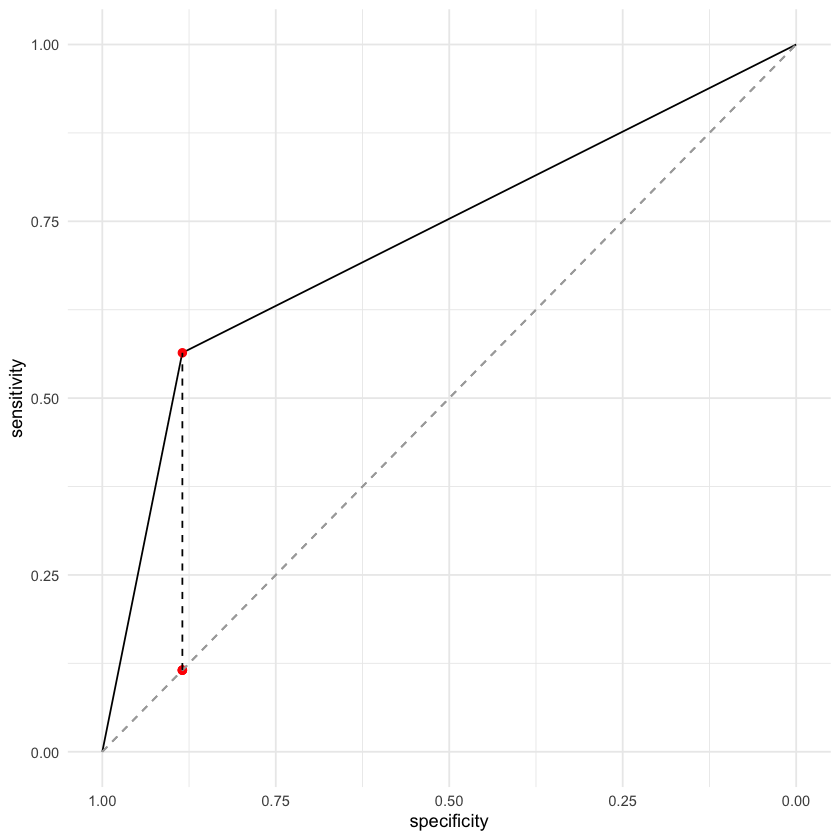

In [23]:
ggroc(roc_obj) +
  geom_point(data = best_thres_data, aes(x = specificity, y = sensitivity), size = 2, color = "red") +
  geom_point(aes(x = best_thres_data$specificity, y = 1 - best_thres_data$specificity), size = 2, color="red") +
  # plotting curve of random classifier
  geom_segment(aes(x = 1, xend = 0, y = 0, yend = 1), color = "darkgrey", linetype = "dashed") +
  # geom_text(data = best_thres_data, aes(x=specificity, y = 0.95, 
  #                                       label=paste0("Threshold = ", round(threshold,2),
  # "\nSensitivity = ", round(sensitivity,2),
  # "\nSpecificity = ", round(specificity,2),
  # "\nAUC = ", round(auc(roc_obj),2)))) +
  geom_line(data=data_add_line, aes(x=specificity, y=sensitvity), linetype="dashed") +
  theme_minimal()